## Import general packages

In [1]:
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Define locations

In [2]:
# Change this to the path of your repo.
loc_main = 'C:\\Users\\johanr\\OneDrive - Ortec B.V\\Data Analysis for Strengths and Weaknesses\\Sustainable_code_structure'

# Define paths inside of our repo
loc_input_data = os.path.join(loc_main, 'data', 'input')
loc_intermediate_data = os.path.join(loc_main, 'data', 'intermediate')
loc_output_data = os.path.join(loc_main, 'data', 'output')
loc_utils = os.path.join(loc_main, 'code')

## Import own functionalities

In [3]:
sys.path.insert(1, loc_utils)
from data_utils import plot12_hist_regression,coloured_scatter_plot,forward_selection,backward_selection,give_measure_of_fit

## Import required data

In [4]:
file = pd.read_csv(loc_output_data+"\\16-05-23_Final_1020.csv")

In [5]:
file=file.reset_index(drop=True)
file=file.rename(columns={'Mean Dist Matrix':'Mean_Dist_Matrix', 'Std Dist Matrix':'Std_Dist_Matrix',
       'Mean Distance Depot Centroid':'Mean_Distance_Depot_Centroid', 'Number of clusters':'Number_of_clusters',
       'Customer Time Window Mean':'Customer_Time_Window_Mean', 'Customer Time Window Std':'Customer_Time_Window_Std',
       'Number of customers':'Number_of_customers', 'Number of vehicles':'Number_of_vehicles',
       'Vehicles Time Window Mean':'Vehicles_Time_Window_Mean', 'Vehicles Time Window Std':'Vehicles_Time_Window_Std',
       'Ortecs Customer':'Ortecs_Customer', 'Customer Demand Location':'Customer_Demand_Location',
       'Vehicle Availability':'Vehicle_Availability_Location', 'Final Cost':'Final_Cost',
       'Number of planned tasks':'Number_of_planned_tasks', 'Cost Array':'Cost_Array', 
       'Time Array':'Time_Array', 'CV Dist Matrix':'CV_Dist_Matrix', 'Number of planned tasks Array':'Task_Array', 'Final Time':'Final_Time'})
file = file.rename(columns={'pct_planned':'planned_pct'})
file=file[file['planned_pct']<1].reset_index(drop=True)

## Figure 5.35 : Feature values against the percentage of planned tasks, along with a linear regression

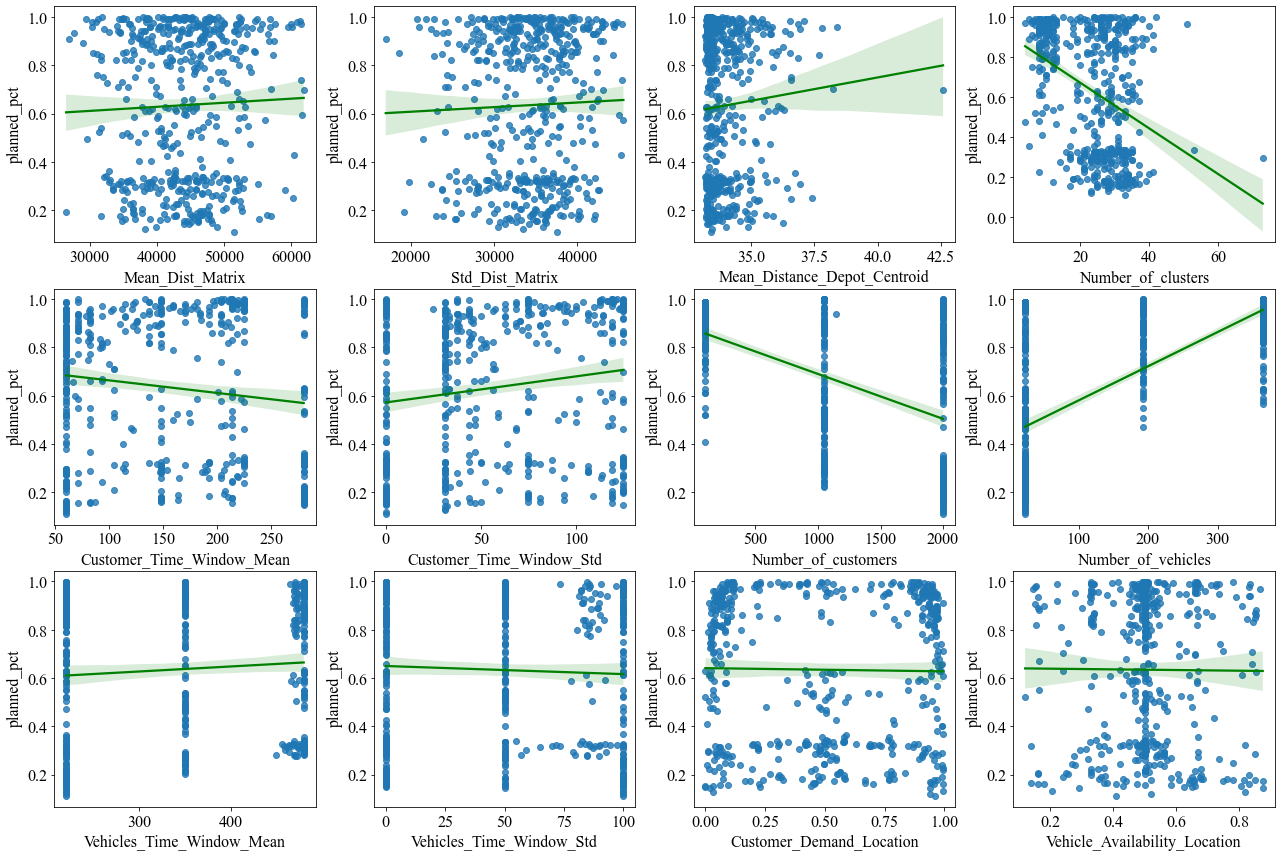

In [6]:
plot12_hist_regression(file,'planned_pct')

## Figure 5.36: Number of customers against number of vehicles coloured by percentage of planned tasks

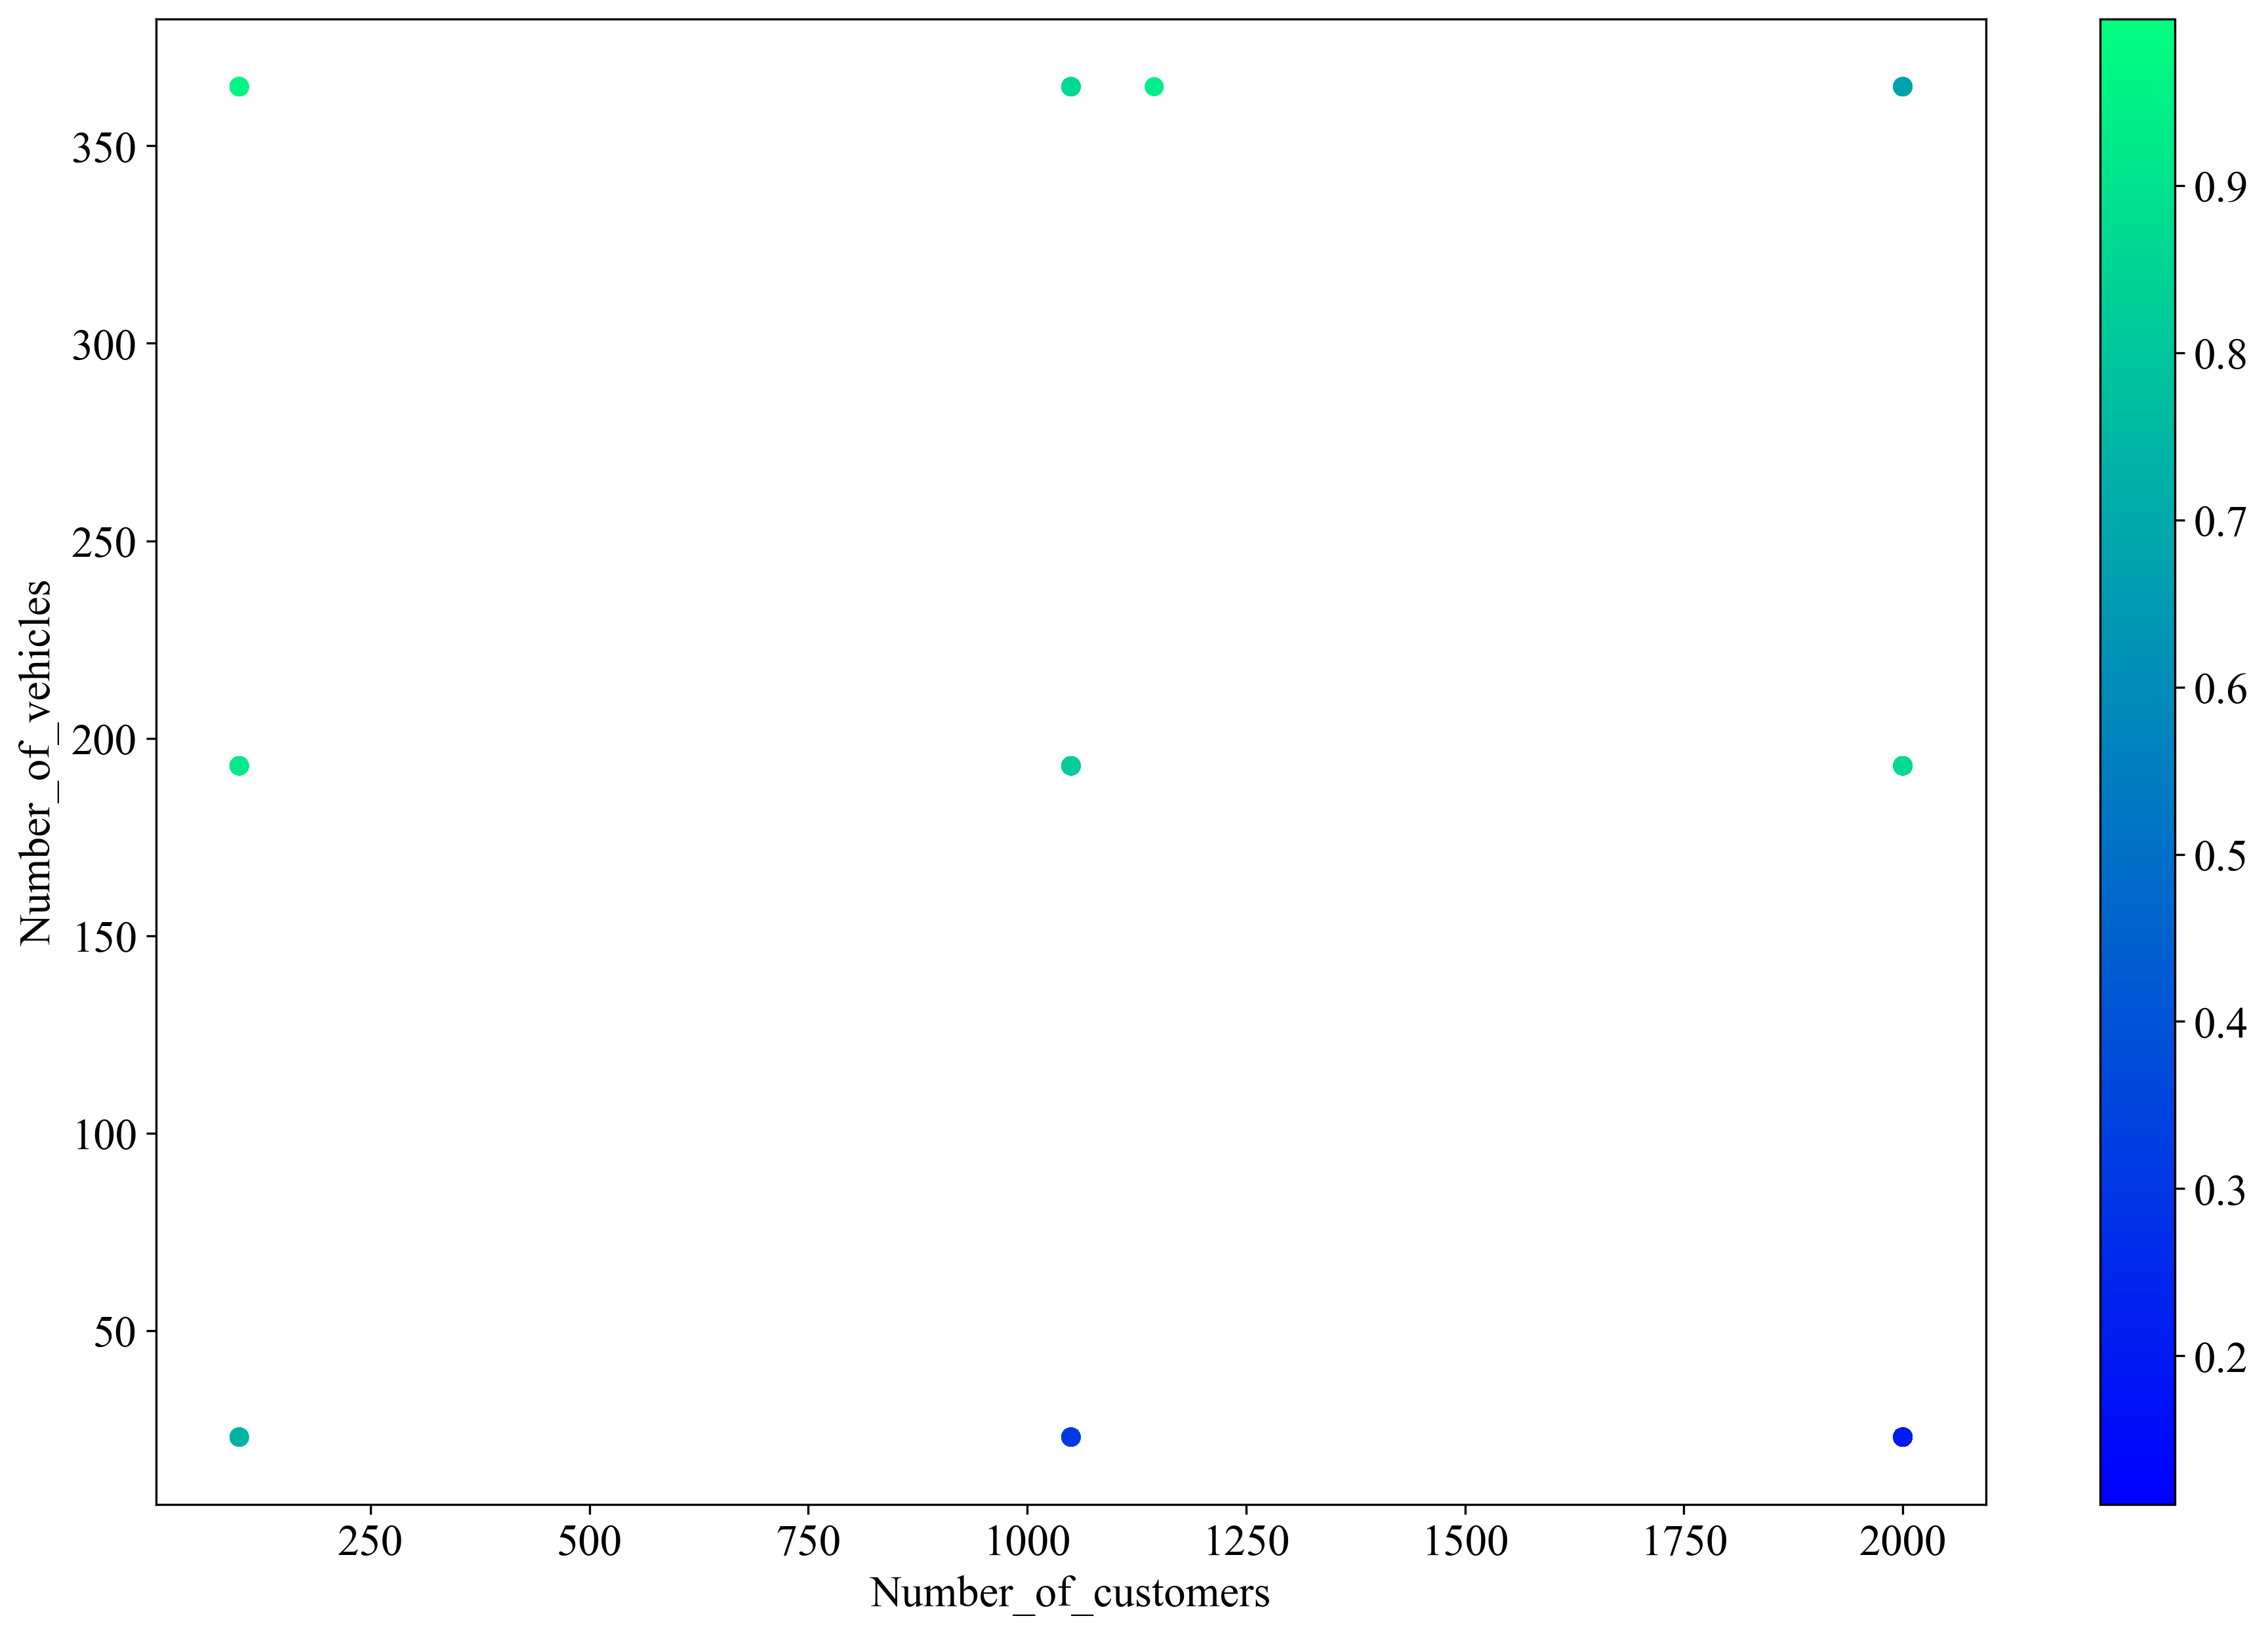

In [7]:
coloured_scatter_plot(file,'Number_of_customers','Number_of_vehicles','planned_pct')

# Linear Regression and ANOVA

In [8]:
interest_columns=[
       'Customer_Time_Window_Mean', 'Customer_Time_Window_Std',
       'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std', 'Customer_Demand_Location',
       'Vehicle_Availability_Location', "planned_pct"]

In [9]:
sc=StandardScaler()
data=sc.fit_transform(file[interest_columns[:-1]])
data=pd.DataFrame(data, columns=interest_columns[:-1])

for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    data[x[0]+"X"+x[1]] = data[x[0]]*data[x[1]]

for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    data[x[0]+"X"+x[0]] = data[x[0]]*data[x[0]]
 

data['planned_pct']=file['planned_pct']

In [10]:
cols = [i for i in data.columns if i!="planned_pct"]

In [11]:
model = ols("planned_pct ~ "+'+'.join(cols), data)
output=model.fit()
print(output.summary())
print("\nRetrieving manually the parameter estimates:")
print(output._results.params)

                            OLS Regression Results                            
Dep. Variable:            planned_pct   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     179.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          6.19e-260
Time:                        01:44:15   Log-Likelihood:                 615.26
No. Observations:                 504   AIC:                            -1141.
Df Residuals:                     459   BIC:                            -950.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [12]:
anova_results = anova_lm(output)
print('\nANOVA results')
print(anova_results)


ANOVA results
                                                       df     sum_sq  \
Customer_Time_Window_Mean                             1.0   0.889591   
Customer_Time_Window_Std                              1.0   2.767917   
Number_of_customers                                   1.0   8.652483   
Number_of_vehicles                                    1.0  21.302371   
Vehicles_Time_Window_Mean                             1.0   0.716365   
Vehicles_Time_Window_Std                              1.0   0.014014   
Customer_Demand_Location                              1.0   0.005559   
Vehicle_Availability_Location                         1.0   0.008855   
Customer_Demand_LocationXVehicle_Availability_L...    1.0   0.454613   
Customer_Demand_LocationXCustomer_Time_Window_Mean    1.0   0.002241   
Customer_Demand_LocationXCustomer_Time_Window_Std     1.0   0.045722   
Customer_Demand_LocationXNumber_of_customers          1.0   0.008383   
Customer_Demand_LocationXNumber_of_vehicles      

In [13]:
list_forward=forward_selection(data[cols], data['planned_pct'])

Add  Number_of_vehicles             with p-value 1.0612e-65
Add  Number_of_customers            with p-value 5.01577e-67
Add  Number_of_customersXNumber_of_vehicles with p-value 6.96517e-43
Add  Number_of_vehiclesXNumber_of_vehicles with p-value 1.4652e-37
Add  Customer_Time_Window_Mean      with p-value 4.92185e-21
Add  Vehicles_Time_Window_Mean      with p-value 8.75764e-27
Add  Number_of_customersXNumber_of_customers with p-value 8.10332e-17
Add  Customer_Demand_LocationXVehicle_Availability_Location with p-value 1.52722e-11
Add  Customer_Time_Window_MeanXNumber_of_vehicles with p-value 1.06463e-11
Add  Customer_Demand_LocationXCustomer_Demand_Location with p-value 2.33999e-11
Add  Customer_Time_Window_MeanXNumber_of_customers with p-value 2.45264e-06
Add  Number_of_vehiclesXVehicles_Time_Window_Mean with p-value 3.34267e-06
Add  Customer_Time_Window_StdXNumber_of_customers with p-value 0.00134401
Add  Customer_Time_Window_StdXNumber_of_vehicles with p-value 0.0045608
Add  Customer_

In [14]:
list_backward=backward_selection(data[cols], data['planned_pct'])

Drop  Vehicle_Availability_LocationXCustomer_Time_Window_Mean with p-value 0.967235
Drop  Customer_Time_Window_Std       with p-value 0.858098
Drop  Customer_Time_Window_StdXCustomer_Time_Window_Std with p-value 0.784076
Drop  Customer_Demand_LocationXVehicles_Time_Window_Mean with p-value 0.773671
Drop  Customer_Demand_LocationXCustomer_Time_Window_Mean with p-value 0.67022
Drop  Vehicle_Availability_LocationXNumber_of_customers with p-value 0.641823
Drop  Customer_Time_Window_StdXVehicles_Time_Window_Mean with p-value 0.636276
Drop  Vehicle_Availability_LocationXVehicles_Time_Window_Std with p-value 0.599674
Drop  Vehicles_Time_Window_StdXVehicles_Time_Window_Std with p-value 0.573771
Drop  Customer_Time_Window_MeanXVehicles_Time_Window_Std with p-value 0.551871
Drop  Customer_Time_Window_StdXVehicles_Time_Window_Std with p-value 0.672759
Drop  Vehicles_Time_Window_Std       with p-value 0.528524
Drop  Customer_Demand_LocationXCustomer_Time_Window_Std with p-value 0.508508
Drop  Numb

In [15]:
list(set(list_backward) & set(list_forward))

['Number_of_vehicles',
 'Number_of_customers',
 'Number_of_customersXNumber_of_vehicles',
 'Vehicles_Time_Window_Mean',
 'Number_of_customersXNumber_of_customers',
 'Customer_Demand_LocationXVehicle_Availability_Location',
 'Customer_Time_Window_MeanXNumber_of_customers',
 'Customer_Demand_LocationXCustomer_Demand_Location',
 'Customer_Time_Window_StdXNumber_of_vehicles',
 'Number_of_vehiclesXVehicles_Time_Window_Mean',
 'Customer_Time_Window_MeanXCustomer_Time_Window_Mean',
 'Customer_Time_Window_Mean',
 'Number_of_vehiclesXNumber_of_vehicles',
 'Customer_Time_Window_MeanXNumber_of_vehicles',
 'Customer_Time_Window_StdXNumber_of_customers']

In [16]:
set(list_backward)-set(list_forward)

set()

In [17]:
model = ols("planned_pct ~ "+'+'.join(list_forward), data)
output=model.fit()
print(output.summary())
print("\nRetrieving manually the parameter estimates:")
print(output._results.params)

                            OLS Regression Results                            
Dep. Variable:            planned_pct   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     529.4
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          1.58e-290
Time:                        01:44:23   Log-Likelihood:                 602.61
No. Observations:                 504   AIC:                            -1173.
Df Residuals:                     488   BIC:                            -1106.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [18]:
anova_results = anova_lm(output)
print('\nANOVA results')
print(anova_results)


ANOVA results
                                                       df     sum_sq  \
Number_of_vehicles                                    1.0  20.643183   
Number_of_customers                                   1.0  11.699446   
Number_of_customersXNumber_of_vehicles                1.0   4.494989   
Number_of_vehiclesXNumber_of_vehicles                 1.0   2.750708   
Customer_Time_Window_Mean                             1.0   1.150966   
Vehicles_Time_Window_Mean                             1.0   1.219297   
Number_of_customersXNumber_of_customers               1.0   0.612537   
Customer_Demand_LocationXVehicle_Availability_L...    1.0   0.358232   
Customer_Time_Window_MeanXNumber_of_vehicles          1.0   0.332225   
Customer_Demand_LocationXCustomer_Demand_Location     1.0   0.293451   
Customer_Time_Window_MeanXNumber_of_customers         1.0   0.136544   
Number_of_vehiclesXVehicles_Time_Window_Mean          1.0   0.127350   
Customer_Time_Window_StdXNumber_of_customers     

# Modelling with all main, interaction and quadratic effects

In [19]:
x_train, x_test, y_train, y_test=train_test_split(file[interest_columns[:-1]],file['planned_pct'],test_size=0.3, random_state=123)

In [20]:
sc=StandardScaler()
data=sc.fit_transform(x_train)
x_train=pd.DataFrame(data, columns=interest_columns[:-1])

data=sc.transform(x_test)
x_test=pd.DataFrame(data, columns=interest_columns[:-1])

In [21]:
for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    x_train[x[0]+"X"+x[1]] = x_train[x[0]]*x_train[x[1]]

for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    x_train[x[0]+"X"+x[0]] = x_train[x[0]]*x_train[x[0]]

for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    x_test[x[0]+"X"+x[1]] = x_test[x[0]]*x_test[x[1]]

for x in itertools.combinations(['Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean',
       'Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    x_test[x[0]+"X"+x[0]] = x_test[x[0]]*x_test[x[0]]

## Linear Regression

In [22]:
lr=LinearRegression()
lr.fit(x_train, y_train)

y_pred_train = lr.predict(x_train)
y_pred = lr.predict(x_test)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9426957969764502
####################################################
R-squared: 0.9230853804486485
Adjusted R-squared: 0.8914569387639806
MAE : 0.06610417439768418
MAE% : 0.10733282815319062
MAPE : 0.15064666205335833
RMSE: 0.08594591823845794
Explained variance ratio: 0.9230887473111729
####################################################



## KNN regression

In [23]:
grid={"n_neighbors":[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50], "weights":['distance', 'uniform']}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn,grid,cv=KFold(10, random_state=123, shuffle=True))
knn_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 3, 'weights': 'distance'}
accuracy : 0.6939409531360953


In [24]:
knn=KNeighborsRegressor(n_neighbors=3, weights='distance')
knn.fit(x_train,y_train)
y_pred_train = knn.predict(x_train)
y_pred = knn.predict(x_test)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9999838710912459
####################################################
R-squared: 0.8081560295671067
Adjusted R-squared: 0.729266920230216
MAE : 0.09132951128853901
MAE% : 0.1468454242671715
MAPE : 0.23017442685470116
RMSE: 0.1357359493718158
Explained variance ratio: 0.8084703522284274
####################################################



## SVM poly kernel

In [25]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['poly'], 'degree':[1, 2, 3]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=2, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=

In [26]:
svc=SVR(C=7.196856730011514, degree=1, kernel='poly')
svc.fit(x_train,y_train)
y_pred_train = svc.predict(x_train)
y_pred = svc.predict(x_test)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9295253047632545
####################################################
R-squared: 0.9145146328530783
Adjusted R-squared: 0.8793617715964003
MAE : 0.07504167665105313
MAE% : 0.12038144113629062
MAPE : 0.1775150929484116
RMSE: 0.0906080321623684
Explained variance ratio: 0.9150128061418529
####################################################



## SVM rbf kernel

In [27]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['rbf'], 'gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10, 100]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=s

In [28]:
svc=SVR(C=51.794746792312125, gamma=0.001, kernel='rbf')
svc.fit(x_train,y_train)
y_pred_train = svc.predict(x_train)
y_pred = svc.predict(x_test)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9402129651112332
####################################################
R-squared: 0.9117375883425205
Adjusted R-squared: 0.8754427648572018
MAE : 0.07564545650262104
MAE% : 0.12249374372161057
MAPE : 0.1700804857454066
RMSE: 0.09206799865871722
Explained variance ratio: 0.9117501083122067
####################################################



## Random Forest Regressor

In [29]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [20, 16, 12, 8, 4], 
    'max_features':['sqrt', 'log2', None]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   1.1s
[CV] END ..max_depth=20, max_features=log2, n_

In [30]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [8], 
    'max_features':[44, 30, 20, 15, 10, 5, 3, 2, 1]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.0s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.2s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.0s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   0.9s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   0.9s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.0s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.0s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   1.0s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   0.9s
[CV] END .....max_depth=8, max_features=44, n_estimators=200; total time=   0.9s
[CV] END .....max_depth=8, max_features=30, n_estimators=200; total time=   0.5s
[CV] END .....max_depth=8, max_features=30, n_es

In [31]:
rf=RandomForestRegressor(max_depth=8, max_features=20, n_estimators=200,random_state=123)
rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
y_pred = rf.predict(x_test)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9916829321274208
####################################################
R-squared: 0.9604592562619306
Adjusted R-squared: 0.9441995111733787
MAE : 0.04229562551630186
MAE% : 0.06925163396187492
MAPE : 0.07282279811689073
RMSE: 0.0616230549748292
Explained variance ratio: 0.9607971089209165
####################################################



## Beta Regression

In [32]:
x_train1 = sm.add_constant(x_train, prepend=False)
x_test1 = sm.add_constant(x_test,prepend=False)

In [33]:
mod = BetaModel(y_train.values.reshape(-1,1),x_train1)
rslt = mod.fit()
print(rslt.summary())

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 552.40
Model:                      BetaModel   AIC:                            -1013.
Method:            Maximum Likelihood   BIC:                            -835.1
Date:                Thu, 01 Jun 2023                                         
Time:                        01:48:27                                         
No. Observations:                 352                                         
Df Residuals:                     306                                         
Df Model:                          45                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Customer_Time_Window_Mean        

In [34]:
rslt.params

Customer_Time_Window_Mean                                      0.614053
Customer_Time_Window_Std                                      -0.042648
Number_of_customers                                           -0.859404
Number_of_vehicles                                             2.051043
Vehicles_Time_Window_Mean                                      0.336107
Vehicles_Time_Window_Std                                      -0.038992
Customer_Demand_Location                                      -0.008873
Vehicle_Availability_Location                                  0.056331
Customer_Demand_LocationXVehicle_Availability_Location         0.221351
Customer_Demand_LocationXCustomer_Time_Window_Mean            -0.088310
Customer_Demand_LocationXCustomer_Time_Window_Std              0.101247
Customer_Demand_LocationXNumber_of_customers                  -0.014578
Customer_Demand_LocationXNumber_of_vehicles                    0.022892
Customer_Demand_LocationXVehicles_Time_Window_Mean             0

In [35]:
give_measure_of_fit(x_train1,y_train,rslt.predict(x_train1),x_test1,y_test,rslt.predict(x_test1))

Training Adjusted R-squared: 0.9626084730424794
####################################################
R-squared: 0.9497859614977617
Adjusted R-squared: 0.9284686810015285
MAE : 0.05273968868451582
MAE% : 0.08508362405480308
MAPE : 0.1296819182880238
RMSE: 0.06944378493687883
Explained variance ratio: 0.9499069099487003
####################################################



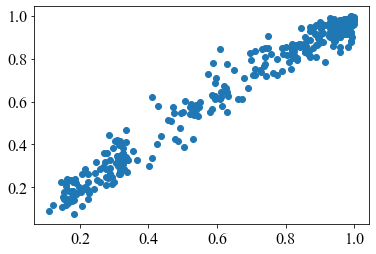

In [36]:
plt.scatter(y_train,rslt.predict(x_train1))

# Modelling with limited variables

## Linear Regression

In [37]:
lr=LinearRegression()
lr.fit(x_train[list_forward], y_train)
y_pred = lr.predict(x_test[list_forward])
y_pred_train = lr.predict(x_train[list_forward])
give_measure_of_fit(x_train[list_forward],y_train,y_pred_train,x_test[list_forward],y_test,y_pred)

Training Adjusted R-squared: 0.9448486732338237
####################################################
R-squared: 0.9272418095416808
Adjusted R-squared: 0.9192170091234838
MAE : 0.06554916951669647
MAE% : 0.10627862638019578
MAPE : 0.14895396874540956
RMSE: 0.0835914295584855
Explained variance ratio: 0.9272428641794479
####################################################



## KNN

In [38]:
grid={"n_neighbors":[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50], "weights":['distance', 'uniform']}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn,grid,cv=KFold(10, random_state=123, shuffle=True))
knn_cv.fit(x_train[list_forward],y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 4, 'weights': 'distance'}
accuracy : 0.9552821458594195


In [39]:
knn=KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(x_train[list_forward],y_train)
y_pred = knn.predict(x_test[list_forward])
y_pred_train = knn.predict(x_train[list_forward])
give_measure_of_fit(x_train[list_forward],y_train,y_pred_train,x_test[list_forward],y_test,y_pred)

Training Adjusted R-squared: 0.9999852631696804
####################################################
R-squared: 0.9613802588013691
Adjusted R-squared: 0.9571207285221084
MAE : 0.039924519917006976
MAE% : 0.0647597431092336
MAPE : 0.07703741427214017
RMSE: 0.06090114913813123
Explained variance ratio: 0.9613802882721333
####################################################



## SVR poly kernel

In [40]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['poly'], 'degree':[1, 2, 3]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train[list_forward],y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=2, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=

In [41]:
svc=SVR(C=1000, degree=1, kernel='poly')
svc.fit(x_train[list_forward],y_train)
y_pred = svc.predict(x_test[list_forward])
y_pred_train = svc.predict(x_train[list_forward])
give_measure_of_fit(x_train[list_forward],y_train,y_pred_train,x_test[list_forward],y_test,y_pred)

Training Adjusted R-squared: 0.9362857306340636
####################################################
R-squared: 0.9125310069680383
Adjusted R-squared: 0.9028836915601014
MAE : 0.07477580608628413
MAE% : 0.12154943317249459
MAPE : 0.16893979529528283
RMSE: 0.09165325035576566
Explained variance ratio: 0.9125475509876746
####################################################



## SVR rbf kernel

In [42]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['rbf'], 'gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10, 100]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train[list_forward],y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=s

In [43]:
svc=SVR(C=1000, gamma=0.001, kernel='rbf')
svc.fit(x_train[list_forward],y_train)
y_pred = svc.predict(x_test[list_forward])
y_pred_train = svc.predict(x_train[list_forward])
give_measure_of_fit(x_train[list_forward],y_train,y_pred_train,x_test[list_forward],y_test,y_pred)

Training Adjusted R-squared: 0.9588385635131912
####################################################
R-squared: 0.9438049830590934
Adjusted R-squared: 0.9376070032494346
MAE : 0.06255933062437029
MAE% : 0.10162109352299124
MAPE : 0.14463509657665782
RMSE: 0.07346317785666923
Explained variance ratio: 0.9438122482115642
####################################################



## Random Forest

In [44]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [20, 16, 12, 8, 4], 
    'max_features':['sqrt', 'log2', None]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train[list_forward], y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=log2, n_

In [45]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [12], 
    'max_features':[15, 10, 5, 3, 2, 1]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train[list_forward], y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.4s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.3s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.3s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.3s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.3s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.4s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.4s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.5s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.5s
[CV] END ....max_depth=12, max_features=15, n_estimators=200; total time=   0.4s
[CV] END ....max_depth=12, max_features=10, n_estimators=200; total time=   0.3s
[CV] END ....max_depth=12, max_features=10, n_es

In [46]:
rf=RandomForestRegressor(max_depth=12, max_features=5, n_estimators=200)
rf.fit(x_train[list_forward], y_train)
y_pred = rf.predict(x_test[list_forward])
y_pred_train = rf.predict(x_train[list_forward])
give_measure_of_fit(x_train[list_forward],y_train,y_pred_train,x_test[list_forward],y_test,y_pred)

Training Adjusted R-squared: 0.994738669361698
####################################################
R-squared: 0.9658200860191561
Adjusted R-squared: 0.9620502425653866
MAE : 0.04023832642226864
MAE% : 0.06569065610137309
MAPE : 0.0702351833115944
RMSE: 0.05729362359372419
Explained variance ratio: 0.9659789748850129
####################################################



## Beta regression

In [47]:
x_train1 = sm.add_constant(x_train[list_forward], prepend=False)
x_test1 = sm.add_constant(x_test[list_forward],prepend=False)

In [48]:
mod = BetaModel(y_train.values.reshape(-1,1),x_train1)
rslt = mod.fit()
print(rslt.summary())

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 534.09
Model:                      BetaModel   AIC:                            -1034.
Method:            Maximum Likelihood   BIC:                            -968.5
Date:                Thu, 01 Jun 2023                                         
Time:                        01:50:23                                         
No. Observations:                 352                                         
Df Residuals:                     335                                         
Df Model:                          16                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Number_of_vehicles                         

In [49]:
give_measure_of_fit(x_train1,y_train,rslt.predict(x_train1),x_test1,y_test,rslt.predict(x_test1))

Training Adjusted R-squared: 0.9634067140227836
####################################################
R-squared: 0.9558163784275364
Adjusted R-squared: 0.9505798010559852
MAE : 0.04979649907854989
MAE% : 0.07992105906346583
MAPE : 0.1269574861463222
RMSE: 0.06514055629496093
Explained variance ratio: 0.9562729967188658
####################################################



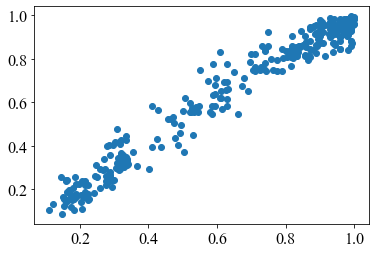

In [50]:
plt.scatter(y_train,rslt.predict(x_train1))

# Linear Regression and ANOVA with all variables (12)

In [51]:
interest_columns=['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters',
       'Customer_Time_Window_Mean', 'Customer_Time_Window_Std',
       'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std', 'Customer_Demand_Location',
       'Vehicle_Availability_Location', "planned_pct"]

In [52]:
sc=StandardScaler()
data=sc.fit_transform(file[interest_columns[:-1]])
data=pd.DataFrame(data, columns=interest_columns[:-1])

In [53]:
for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    data[x[0]+"X"+x[1]] = data[x[0]]*data[x[1]]

for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    data[x[0]+"X"+x[0]] = data[x[0]]*data[x[0]]

data['planned_pct']=file['planned_pct']

In [54]:
cols = [i for i in data.columns if i!="planned_pct"]

In [55]:
model = ols("planned_pct ~ "+'+'.join(cols), data)
output=model.fit()
print(output.summary())
print("\nRetrieving manually the parameter estimates:")
print(output._results.params)

                            OLS Regression Results                            
Dep. Variable:            planned_pct   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     95.80
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          6.12e-229
Time:                        01:50:25   Log-Likelihood:                 662.13
No. Observations:                 504   AIC:                            -1142.
Df Residuals:                     413   BIC:                            -758.0
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [56]:
anova_results = anova_lm(output)
print('\nANOVA results')
print(anova_results)


ANOVA results
                                                       df    sum_sq   mean_sq  \
Mean_Dist_Matrix                                      1.0  0.065367  0.065367   
Std_Dist_Matrix                                       1.0  0.000103  0.000103   
Mean_Distance_Depot_Centroid                          1.0  0.124012  0.124012   
Number_of_clusters                                    1.0  6.297800  6.297800   
Customer_Time_Window_Mean                             1.0  0.337418  0.337418   
...                                                   ...       ...       ...   
Number_of_customersXNumber_of_customers               1.0  0.175972  0.175972   
Number_of_vehiclesXNumber_of_vehicles                 1.0  2.547895  2.547895   
Vehicles_Time_Window_MeanXVehicles_Time_Window_...    1.0  0.022613  0.022613   
Vehicles_Time_Window_StdXVehicles_Time_Window_Std     1.0  0.000318  0.000318   
Residual                                            413.0  2.132337  0.005163   

            

In [57]:
list_forward=forward_selection(data[cols], data['planned_pct'])

Add  Number_of_vehicles             with p-value 1.0612e-65
Add  Number_of_customers            with p-value 5.01577e-67
Add  Number_of_customersXNumber_of_vehicles with p-value 6.96517e-43
Add  Number_of_vehiclesXNumber_of_vehicles with p-value 1.4652e-37
Add  Customer_Time_Window_Mean      with p-value 4.92185e-21
Add  Vehicles_Time_Window_Mean      with p-value 8.75764e-27
Add  Number_of_customersXNumber_of_customers with p-value 8.10332e-17
Add  Customer_Demand_LocationXVehicle_Availability_Location with p-value 1.52722e-11
Add  Customer_Time_Window_MeanXNumber_of_vehicles with p-value 1.06463e-11
Add  Customer_Demand_LocationXCustomer_Demand_Location with p-value 2.33999e-11
Add  Customer_Time_Window_MeanXNumber_of_customers with p-value 2.45264e-06
Add  Number_of_vehiclesXVehicles_Time_Window_Mean with p-value 3.34267e-06
Add  Number_of_clustersXCustomer_Time_Window_Std with p-value 0.00114282
Add  Mean_Distance_Depot_Centroid   with p-value 0.00352864
Add  Customer_Time_Window_S

In [58]:
list_backward=backward_selection(data[cols], data['planned_pct'])

Drop  Number_of_clustersXCustomer_Demand_Location with p-value 0.996517
Drop  Mean_Distance_Depot_CentroidXNumber_of_clusters with p-value 0.975613
Drop  Customer_Time_Window_Std       with p-value 0.975886
Drop  Std_Dist_MatrixXMean_Distance_Depot_Centroid with p-value 0.97013
Drop  Mean_Distance_Depot_CentroidXCustomer_Demand_Location with p-value 0.963051
Drop  Mean_Distance_Depot_CentroidXVehicles_Time_Window_Mean with p-value 0.956429
Drop  Vehicle_Availability_LocationXNumber_of_customers with p-value 0.944684
Drop  Customer_Demand_LocationXVehicles_Time_Window_Mean with p-value 0.938629
Drop  Customer_Time_Window_StdXCustomer_Time_Window_Std with p-value 0.926168
Drop  Customer_Time_Window_StdXVehicles_Time_Window_Mean with p-value 0.884063
Drop  Mean_Dist_MatrixXMean_Distance_Depot_Centroid with p-value 0.876819
Drop  Vehicle_Availability_Location  with p-value 0.861934
Drop  Vehicles_Time_Window_StdXVehicles_Time_Window_Std with p-value 0.813921
Drop  Customer_Time_Window_StdX

In [59]:
list(set(list_backward) & set(list_forward))

['Number_of_vehicles',
 'Number_of_customers',
 'Number_of_customersXNumber_of_vehicles',
 'Vehicles_Time_Window_Mean',
 'Customer_Demand_LocationXVehicle_Availability_Location',
 'Customer_Time_Window_MeanXNumber_of_customers',
 'Std_Dist_MatrixXNumber_of_vehicles',
 'Mean_Dist_MatrixXVehicles_Time_Window_Std',
 'Number_of_customersXNumber_of_customers',
 'Customer_Demand_LocationXCustomer_Demand_Location',
 'Mean_Distance_Depot_CentroidXMean_Distance_Depot_Centroid',
 'Customer_Time_Window_StdXNumber_of_vehicles',
 'Number_of_vehiclesXVehicles_Time_Window_Mean',
 'Mean_Distance_Depot_CentroidXNumber_of_customers',
 'Customer_Time_Window_Mean',
 'Number_of_clustersXVehicles_Time_Window_Mean',
 'Number_of_vehiclesXNumber_of_vehicles',
 'Customer_Time_Window_MeanXNumber_of_vehicles']

In [60]:
set(list_backward)-set(list_forward)

{'Customer_Time_Window_MeanXCustomer_Time_Window_Std',
 'Customer_Time_Window_StdXNumber_of_customers',
 'Mean_Dist_MatrixXCustomer_Demand_Location',
 'Mean_Dist_MatrixXNumber_of_vehicles',
 'Mean_Distance_Depot_CentroidXCustomer_Time_Window_Mean',
 'Mean_Distance_Depot_CentroidXNumber_of_vehicles',
 'Std_Dist_MatrixXCustomer_Demand_Location',
 'Vehicles_Time_Window_MeanXVehicles_Time_Window_Mean'}

In [61]:
set(list_forward)-set(list_backward)

{'Mean_Distance_Depot_Centroid', 'Number_of_clustersXCustomer_Time_Window_Std'}

In [62]:
model = ols("planned_pct ~ "+'+'.join(list(set(list_backward) & set(list_forward))), data)
output=model.fit()
print(output.summary())
print("\nRetrieving manually the parameter estimates:")
print(output._results.params)

                            OLS Regression Results                            
Dep. Variable:            planned_pct   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     459.5
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          4.28e-291
Time:                        01:50:37   Log-Likelihood:                 613.71
No. Observations:                 504   AIC:                            -1189.
Df Residuals:                     485   BIC:                            -1109.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [63]:
anova_results = anova_lm(output)
print('\nANOVA results')
print(anova_results)


ANOVA results
                                                       df     sum_sq  \
Number_of_vehicles                                    1.0  20.643183   
Number_of_customers                                   1.0  11.699446   
Number_of_customersXNumber_of_vehicles                1.0   4.494989   
Vehicles_Time_Window_Mean                             1.0   0.920274   
Customer_Demand_LocationXVehicle_Availability_L...    1.0   0.360078   
Customer_Time_Window_MeanXNumber_of_customers         1.0   0.000629   
Std_Dist_MatrixXNumber_of_vehicles                    1.0   0.067959   
Mean_Dist_MatrixXVehicles_Time_Window_Std             1.0   0.079888   
Number_of_customersXNumber_of_customers               1.0   0.409860   
Customer_Demand_LocationXCustomer_Demand_Location     1.0   0.722110   
Mean_Distance_Depot_CentroidXMean_Distance_Depo...    1.0   0.066192   
Customer_Time_Window_StdXNumber_of_vehicles           1.0   0.117023   
Number_of_vehiclesXVehicles_Time_Window_Mean     

# Modelling with all variables

In [64]:
x_train, x_test, y_train, y_test=train_test_split(file[interest_columns[:-1]],file['planned_pct'],test_size=0.3, random_state=123)

In [65]:
sc=StandardScaler()
data=sc.fit_transform(x_train)
x_train=pd.DataFrame(data, columns=interest_columns[:-1])

data=sc.transform(x_test)
x_test=pd.DataFrame(data, columns=interest_columns[:-1])

In [66]:
for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    x_train[x[0]+"X"+x[1]] = x_train[x[0]]*x_train[x[1]]

for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    x_train[x[0]+"X"+x[0]] = x_train[x[0]]*x_train[x[0]]

for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 2):
    x_test[x[0]+"X"+x[1]] = x_test[x[0]]*x_test[x[1]]

for x in itertools.combinations(['Mean_Dist_Matrix', 'Std_Dist_Matrix',
       'Mean_Distance_Depot_Centroid', 'Number_of_clusters','Customer_Demand_Location', 'Vehicle_Availability_Location', 'Customer_Time_Window_Mean','Customer_Time_Window_Std', 'Number_of_customers', 'Number_of_vehicles',
       'Vehicles_Time_Window_Mean', 'Vehicles_Time_Window_Std'], 1):
    x_test[x[0]+"X"+x[0]] = x_test[x[0]]*x_test[x[0]]

## Linear Regression

In [67]:
lr=LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_train = lr.predict(x_train)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9486400742307278
####################################################
R-squared: 0.9104316641776222
Adjusted R-squared: 0.7782816605052616
MAE : 0.07256062263957072
MAE% : 0.11788984462041735
MAPE : 0.17590584642201607
RMSE: 0.09274661336784923
Explained variance ratio: 0.9104411373952659
####################################################



## KNN

In [68]:
grid={"n_neighbors":[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50], "weights":['distance', 'uniform']}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn,grid,cv=KFold(10, random_state=123, shuffle=True))
knn_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 5, 'weights': 'distance'}
accuracy : 0.5518927186025234


In [69]:
knn=KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
y_pred_train = knn.predict(x_train)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9999999999999992
####################################################
R-squared: 0.6785666908529567
Adjusted R-squared: 0.20432082489830272
MAE : 0.1354861928238058
MAE% : 0.22086401636010533
MAPE : 0.35987325690685096
RMSE: 0.17569776924506475
Explained variance ratio: 0.6786611417640231
####################################################



## SVR poly kernel

In [70]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['poly'], 'degree':[1, 2, 3]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=2, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=

In [71]:
svc=SVR(C=7.196856730011514, degree=1, kernel='poly')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
y_pred_train = svc.predict(x_train)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9244719324362325
####################################################
R-squared: 0.8977932264162543
Adjusted R-squared: 0.7469963473582687
MAE : 0.07940712674617807
MAE% : 0.12725919657900522
MAPE : 0.18543385697457082
RMSE: 0.09907421666653758
Explained variance ratio: 0.8983837139201737
####################################################



## SVR rbf kernel

In [72]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['rbf'], 'gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10, 100]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train,y_train)
print("tuned hyperparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=s

In [73]:
svc=SVR(C=51.794746792312125, gamma=0.001, kernel='rbf')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
y_pred_train = svc.predict(x_train)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9210750835080623
####################################################
R-squared: 0.885443806627884
Adjusted R-squared: 0.7164264721444342
MAE : 0.08475965506999304
MAE% : 0.1354553065359886
MAPE : 0.1964363446741854
RMSE: 0.10488903618688579
Explained variance ratio: 0.886342449100919
####################################################



## Random Forest

In [74]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [20, 16, 12, 8, 4], 
    'max_features':['sqrt', 'log2', None]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=20, max_features=log2, n_

In [75]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [8], 
    'max_features':[90, 75, 60, 45, 30, 20, 15, 10, 5, 3, 2, 1]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.5s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.4s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.4s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.7s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   2.0s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   2.0s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   2.1s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   2.3s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.9s
[CV] END .....max_depth=8, max_features=90, n_estimators=200; total time=   1.8s
[CV] END .....max_depth=8, max_features=75, n_estimators=200; total time=   1.4s
[CV] END .....max_depth=8, max_features=75, n_

In [76]:
rf=RandomForestRegressor(max_depth=8, max_features=75, n_estimators=200)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)
give_measure_of_fit(x_train,y_train,y_pred_train,x_test,y_test,y_pred)

Training Adjusted R-squared: 0.9903736608867535
####################################################
R-squared: 0.9530120946250282
Adjusted R-squared: 0.8836856768586765
MAE : 0.046559605898701645
MAE% : 0.07652365006145627
MAPE : 0.07836526841415878
RMSE: 0.06717595520152331
Explained variance ratio: 0.9536809566980015
####################################################



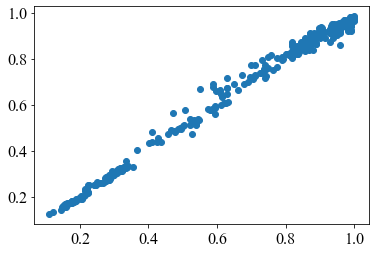

In [77]:
plt.scatter(y_train,rf.predict(x_train))

(array([  2.,   3.,  11.,  16.,  63., 166.,  74.,  13.,   3.,   1.]),
 array([-0.11589238, -0.09420225, -0.07251212, -0.05082199, -0.02913186,
        -0.00744173,  0.0142484 ,  0.03593853,  0.05762866,  0.07931878,
         0.10100891]),
 <BarContainer object of 10 artists>)

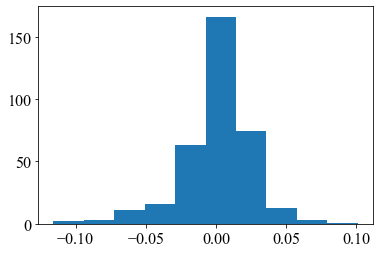

In [78]:
plt.hist(y_train-rf.predict(x_train))

## Beta Regression

In [79]:
x_train1 = sm.add_constant(x_train, prepend=False)
x_test1 = sm.add_constant(x_test,prepend=False)

In [80]:
mod = BetaModel(y_train.values.reshape(-1,1),x_train1)
rslt = mod.fit()
print(rslt.summary())

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 587.50
Model:                      BetaModel   AIC:                            -991.0
Method:            Maximum Likelihood   BIC:                            -635.6
Date:                Thu, 01 Jun 2023                                         
Time:                        01:56:10                                         
No. Observations:                 352                                         
Df Residuals:                     260                                         
Df Model:                          91                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Mean_Dist_Matrix                 

In [81]:
give_measure_of_fit(x_train1,y_train,rslt.predict(x_train1),x_test1,y_test,rslt.predict(x_test1))

Training Adjusted R-squared: 0.9646396111910156
####################################################
R-squared: 0.9295304697495197
Adjusted R-squared: 0.8226516822029579
MAE : 0.0626739031390226
MAE% : 0.10064387879361193
MAPE : 0.15993546813739143
RMSE: 0.08226621117758683
Explained variance ratio: 0.9299411872623085
####################################################



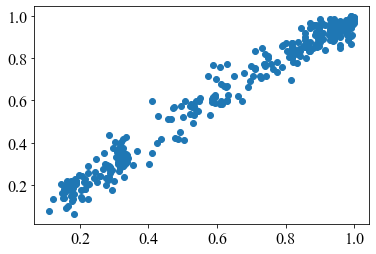

In [82]:
plt.scatter(y_train,rslt.predict(x_train1))

(array([ 8., 17., 22., 15., 43., 50., 24., 16., 28., 23.]),
 array([-0.81175071, -0.64559351, -0.47943631, -0.31327911, -0.14712191,
         0.01903529,  0.18519249,  0.3513497 ,  0.5175069 ,  0.6836641 ,
         0.8498213 ]),
 <BarContainer object of 10 artists>)

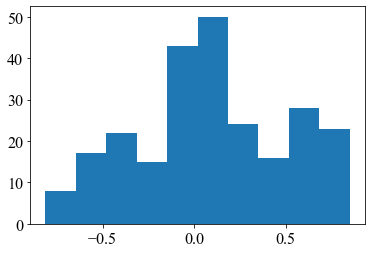

In [83]:
plt.hist(y_train-rslt.predict(x_train1))

# Modelling with limited number of variables

## Linear Regression

In [84]:
lr=LinearRegression()
lr.fit(x_train[list(set(list_backward) & set(list_forward))], y_train)
y_pred = lr.predict(x_test[list(set(list_backward) & set(list_forward))])
y_pred_train = lr.predict(x_train[list(set(list_backward) & set(list_forward))])
give_measure_of_fit(x_train[list(set(list_backward) & set(list_forward))],y_train,y_pred_train,x_test[list(set(list_backward) & set(list_forward))],y_test,y_pred)

Training Adjusted R-squared: 0.9480361928670225
####################################################
R-squared: 0.92684281522478
Adjusted R-squared: 0.9169418428491862
MAE : 0.0647258926666387
MAE% : 0.10475108790336261
MAPE : 0.14215508680446584
RMSE: 0.08382031722815032
Explained variance ratio: 0.9268647962720301
####################################################



## KNN

In [85]:
grid={"n_neighbors":[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50], "weights":['distance', 'uniform']}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn,grid,cv=KFold(10, random_state=123, shuffle=True))
knn_cv.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 4, 'weights': 'distance'}
accuracy : 0.9129406070404655


In [86]:
knn=KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
y_pred = knn.predict(x_test[list(set(list_backward) & set(list_forward))])
y_pred_train = knn.predict(x_train[list(set(list_backward) & set(list_forward))])
give_measure_of_fit(x_train[list(set(list_backward) & set(list_forward))],y_train,y_pred_train,x_test[list(set(list_backward) & set(list_forward))],y_test,y_pred)

Training Adjusted R-squared: 0.9999999999999998
####################################################
R-squared: 0.9454912365812529
Adjusted R-squared: 0.9381141107050315
MAE : 0.047834771792908966
MAE% : 0.07746548710915506
MAPE : 0.10196377417650952
RMSE: 0.07235257176671402
Explained variance ratio: 0.9455026927575048
####################################################



## SVR poly kernel

In [87]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['poly'], 'degree':[1, 2, 3]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=2, kernel=poly; total time=   0.0s
[CV] END .....................C=0.001, degree=

In [88]:
svc=SVR(C=51.794746792312125, degree=1, kernel='poly')
svc.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
y_pred = svc.predict(x_test[list(set(list_backward) & set(list_forward))])
y_pred_train = svc.predict(x_train[list(set(list_backward) & set(list_forward))])
give_measure_of_fit(x_train[list(set(list_backward) & set(list_forward))],y_train,y_pred_train,x_test[list(set(list_backward) & set(list_forward))],y_test,y_pred)

Training Adjusted R-squared: 0.9409745649290618
####################################################
R-squared: 0.9183991167943568
Adjusted R-squared: 0.9073553882402097
MAE : 0.07112793047865948
MAE% : 0.11474586958752092
MAPE : 0.1583272526338221
RMSE: 0.08852546924415691
Explained variance ratio: 0.9185212360177686
####################################################



## SVR rbf kernel

In [89]:
grid={"C":np.logspace(-3, 3, 15), "kernel":['rbf'], 'gamma':['auto', 'scale', 0.001, 0.01, 0.1, 1, 10, 100]}
svr=SVR()
svr_cv=GridSearchCV(svr,grid,cv=KFold(10, random_state=123, shuffle=True), verbose=2)
svr_cv.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
print("tuned hpyerparameters :(best parameters) ",svr_cv.best_params_)
print("accuracy :",svr_cv.best_score_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.001, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.001, gamma=s

In [90]:
svc=SVR(C=7.196856730011514, gamma=0.01, kernel='rbf')
svc.fit(x_train[list(set(list_backward) & set(list_forward))],y_train)
y_pred = svc.predict(x_test[list(set(list_backward) & set(list_forward))])
y_pred_train = svc.predict(x_train[list(set(list_backward) & set(list_forward))])
give_measure_of_fit(x_train[list(set(list_backward) & set(list_forward))],y_train,y_pred_train,x_test[list(set(list_backward) & set(list_forward))],y_test,y_pred)

Training Adjusted R-squared: 0.9516379290156303
####################################################
R-squared: 0.9326396614018363
Adjusted R-squared: 0.9235232245990773
MAE : 0.06396390614879519
MAE% : 0.10398577961816893
MAPE : 0.1555620493066904
RMSE: 0.08043090189218619
Explained variance ratio: 0.932658004607583
####################################################



## Random Forest

In [91]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [20, 16, 12, 8, 4], 
    'max_features':['sqrt', 'log2', None]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train[list(set(list_backward) & set(list_forward))], y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=20, max_features=log2, n_

In [97]:
rf=RandomForestRegressor(random_state=123)
params={'n_estimators': [200],
    'max_depth' : [8], 
    'max_features':[20, 15, 10, 5, 3, 2, 1]}
gs=GridSearchCV(rf, params, verbose=2, cv=KFold(10, random_state=123, shuffle=True))
gs.fit(x_train[list(set(list_backward) & set(list_forward))], y_train)
print("tuned hpyerparameters :(best parameters) ",gs.best_params_)
print("accuracy :",gs.best_score_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=20, n_estimators=200; total time=   0.0s
[CV] END .....max_depth=8, max_features=15, n_estimators=200; total time=   0.1s
[CV] END .....max_depth=8, max_features=15, n_es

c:\Users\johanr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johanr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johanr\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\johanr\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\johanr\Anaconda3\lib\site-packag

tuned hpyerparameters :(best parameters)  {'max_depth': 8, 'max_features': 10, 'n_estimators': 200}
accuracy : 0.9614532256003121


In [98]:
rf=RandomForestRegressor(max_depth=8, max_features=10, n_estimators=200)
rf.fit(x_train[list(set(list_backward) & set(list_forward))], y_train)
y_pred = rf.predict(x_test[list(set(list_backward) & set(list_forward))])
y_pred_train = rf.predict(x_train[list(set(list_backward) & set(list_forward))])
give_measure_of_fit(x_train[list(set(list_backward) & set(list_forward))],y_train,y_pred_train,x_test[list(set(list_backward) & set(list_forward))],y_test,y_pred)

Training Adjusted R-squared: 0.9932733500076627
####################################################
R-squared: 0.9643967037843308
Adjusted R-squared: 0.9595782125671726
MAE : 0.04149501762122553
MAE% : 0.06828120240211272
MAPE : 0.06884335664642184
RMSE: 0.05847441849269382
Explained variance ratio: 0.9651923068658259
####################################################



## Beta Regression

In [94]:
x_train1 = sm.add_constant(x_train[list(set(list_backward) & set(list_forward))], prepend=False)
x_test1 = sm.add_constant(x_test[list(set(list_backward) & set(list_forward))],prepend=False)

In [95]:
mod = BetaModel(y_train.values.reshape(-1,1),x_train1)
rslt = mod.fit()
print(rslt.summary())

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 540.58
Model:                      BetaModel   AIC:                            -1041.
Method:            Maximum Likelihood   BIC:                            -963.9
Date:                Thu, 01 Jun 2023                                         
Time:                        02:00:39                                         
No. Observations:                 352                                         
Df Residuals:                     332                                         
Df Model:                          19                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Number_of_vehicles                   

In [96]:
give_measure_of_fit(x_train1,y_train,rslt.predict(x_train1),x_test1,y_test,rslt.predict(x_test1))

Training Adjusted R-squared: 0.964101365606921
####################################################
R-squared: 0.9530806041117916
Adjusted R-squared: 0.9463270547036404
MAE : 0.05083638791794097
MAE% : 0.08151505060879066
MAPE : 0.12696055026421052
RMSE: 0.06712696526542396
Explained variance ratio: 0.953619681471106
####################################################

